In [1]:
# --- 0. 환경 설정 및 라이브러리 임포트 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sys
import re

# Matplotlib 한글 폰트 설정
!sudo apt-get install -y fonts-nanum > /dev/null
!sudo fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib

plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Google Drive 내 파일이 있는 폴더 경로로 변경
DRIVE_PATH = '/content/drive/MyDrive/data/25년 추계 학술'
FILE_POP = '/content/drive/MyDrive/data/시도별 응급기관 접근/연령별인구현황_연간.xlsx'
FILE_EM_INST_MAIN = "/content/drive/MyDrive/data/시도별 응급기관 접근/1. 응급의료기관 현황.xlsx"
FILE_EM_INST_SUB = "/content/drive/MyDrive/data/시도별 응급기관 접근/2. 응급의료기관 외의 의료기관(응급의료시설).xlsx"

In [11]:
# --- 헬퍼 함수 ---

def clean_col_name(col):
    """컬럼 이름 정규화 헬퍼 함수"""
    col = str(col).strip()
    col = col.replace(' ', '')
    col = col.replace('(선별포함)', '')
    col = re.sub(r'[^가-힣A-Za-z0-9]', '', col)
    return col

def clean_sido_name(sido):
    """시도 이름을 '서울', '경기'와 같은 약어 형태로 정규화"""
    sido = str(sido).strip()
    sido = re.sub(r'(광역시|특별시|특별자치시|도|특별자치도)', '', sido, flags=re.UNICODE).strip()
    sido_map = {
        '충청북': '충북', '충청남': '충남', '전라남': '전남',
        '경상북': '경북', '경상남': '경남'
    }
    return sido_map.get(sido, sido)

def load_and_validate_file(file_path, header_candidates, required_cols):
    """
    다양한 인코딩/헤더로 파일을 로드하고 컬럼을 정규화하며 필수 컬럼을 검증하는 함수.
    CSV 또는 Excel 파일을 지원합니다.
    """
    file_type = file_path.split('.')[-1].lower()
    load_func = None
    if file_type == 'csv':
        load_func = pd.read_csv
    elif file_type == 'xlsx':
        load_func = pd.read_excel
    else:
        print(f"Unsupported file type: {file_type} for {file_path}")
        return None

    encodings = ['utf-8', 'euc-kr', 'cp949', None] # None for pandas default
    for header_index in header_candidates:
        for enc in encodings:
            try:
                if load_func == pd.read_excel:
                    df = load_func(file_path, header=header_index, engine='openpyxl')
                else: # csv
                    df = load_func(file_path, encoding=enc, header=header_index)

                df.columns = [clean_col_name(col) for col in df.columns.tolist()]

                # Validate required columns
                missing_cols = [col for col in required_cols if col not in df.columns]
                if not missing_cols:
                    print(f"Successfully loaded {file_path} with header {header_index} and encoding {enc}.")
                    return df
                else:
                    # print(f"Missing required columns {missing_cols} after loading {file_path} with header {header_index} and encoding {enc}.")
                    continue

            except Exception as e:
                # print(f"Attempt failed for {file_path} with header {header_index}, encoding {enc}: {e}")
                continue
    print(f"Failed to load and validate {file_path} after trying all options.")
    return None

In [12]:
# --- 1. 데이터 로드 및 전처리 ---
# Define required columns for each file
DF_EM_MAIN_COLS = ['지역', '의료기관분류']
DF_EM_SUB_COLS = ['지역', '의료기관분류']
DF_POP_COLS = ['행정기관', '총거주자수', '09세', '1019세', '2029세', '3039세', '4049세', '5059세', '6069세', '7079세', '8089세', '9099세', '100세이상']

# Load files using the robust function
df_em_main = load_and_validate_file(FILE_EM_INST_MAIN, header_candidates=[4, 3, 0], required_cols=DF_EM_MAIN_COLS)
df_em_sub = load_and_validate_file(FILE_EM_INST_SUB, header_candidates=[3, 4, 0], required_cols=DF_EM_SUB_COLS)
df_pop = load_and_validate_file(FILE_POP, header_candidates=[0], required_cols=DF_POP_COLS)


if df_em_main is None or df_em_sub is None or df_pop is None:
    sys.exit("필수 파일 로드 실패. 파일명 또는 헤더를 확인하십시오.")

# The dataframes are loaded successfully if the code reaches here.
# Further processing is done in subsequent cells (sGNIaivOOiqC, h_nu1ckJOkZl).
print("All required files loaded successfully.")

Successfully loaded /content/drive/MyDrive/data/시도별 응급기관 접근/1. 응급의료기관 현황.xlsx with header 4 and encoding utf-8.
Successfully loaded /content/drive/MyDrive/data/시도별 응급기관 접근/2. 응급의료기관 외의 의료기관(응급의료시설).xlsx with header 3 and encoding utf-8.
Successfully loaded /content/drive/MyDrive/data/시도별 응급기관 접근/연령별인구현황_연간.xlsx with header 0 and encoding utf-8.
All required files loaded successfully.


In [13]:
# 1-1. 응급 의료기관 (메인/서브) 병합 및 집계
df_em_main = df_em_main.rename(columns={'지역': '시도', '의료기관분류': '기관유형'})
df_em_sub = df_em_sub.rename(columns={'지역': '시도', '의료기관분류': '기관유형'})

df_em_main = df_em_main[['시도', '기관유형']].copy()
df_em_sub = df_em_sub[['시도', '기관유형']].copy()
df_em_sub['기관유형'] = '응급의료시설' # 명칭 통일

for df in [df_em_main, df_em_sub]:
    df['시도'] = df['시도'].apply(clean_sido_name)

df_emergency = pd.concat([df_em_main, df_em_sub], ignore_index=True)
df_em_count = df_emergency.groupby(['시도', '기관유형']).size().reset_index(name='기관수')
df_em_pivot = df_em_count.pivot(index='시도', columns='기관유형', values='기관수').fillna(0)

In [14]:
# 1-2. 인구 현황 데이터 처리 (총인구 및 고령화율)
age_cols = ['09세', '1019세', '2029세', '3039세', '4049세', '5059세', '6069세', '7079세', '8089세', '9099세', '100세이상']
df_pop = df_pop.rename(columns={'행정기관': '시도', '총거주자수': '총인구'})
df_pop = df_pop[df_pop['시도'] != '전국']
df_pop['시도'] = df_pop['시도'].astype(str).str.strip()
df_pop = df_pop[~df_pop['시도'].str.contains('계')]
df_pop['시도'] = df_pop['시도'].apply(clean_sido_name)

cols_to_convert = ['총인구'] + age_cols
for col in cols_to_convert:
    df_pop[col] = df_pop[col].astype(str).str.replace(',', '', regex=False).astype(float)

df_pop['고령인구'] = (df_pop['6069세'] * 0.5) + df_pop['7079세'] + df_pop['8089세'] + df_pop['9099세'] + df_pop['100세이상']
df_pop['고령화율'] = (df_pop['고령인구'] / df_pop['총인구']) * 100

df_pop_sido = df_pop.groupby('시도')[['총인구', '고령화율']].first().reset_index()

In [15]:
# --- 2. 데이터 병합 및 접근성 지표 계산 ---
df_merged = pd.merge(df_em_pivot.reset_index(), df_pop_sido, on='시도', how='inner')

# 10만 명당 기관 수 계산 (ML 피처로 사용)
institution_types = df_em_pivot.columns.tolist()
for col in institution_types:
    df_merged[f'10만명당{col}'] = np.where(df_merged['총인구'] > 0,
                                            (df_merged[col] / df_merged['총인구']) * 100000,
                                            0)

df_accessibility = df_merged[['시도'] + [f'10만명당{col}' for col in institution_types]].copy()

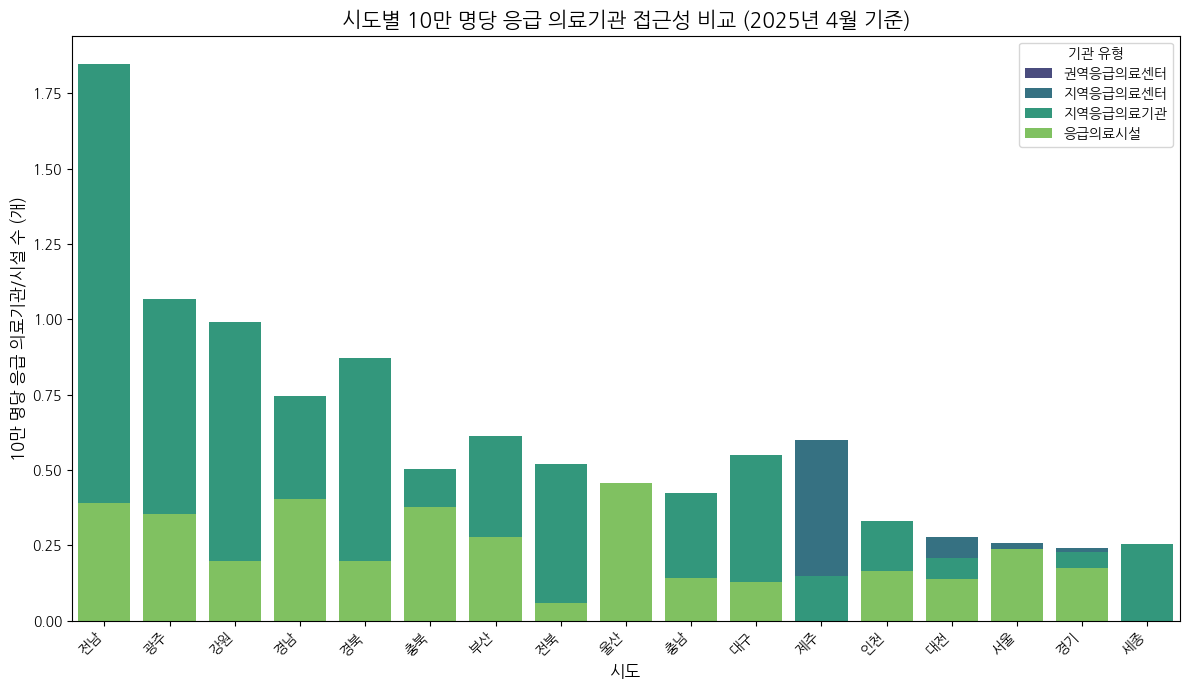

In [16]:
# --- 4. 막대 그래프 시각화 (Step 4) ---

# 시각화를 위해 long format으로 변환
df_accessibility_long = pd.melt(df_accessibility, id_vars='시도', var_name='기관유형', value_name='10만명당기관수')
df_accessibility_long['기관유형'] = df_accessibility_long['기관유형'].str.replace('10만명당', '')

# 기관유형 정렬 순서 정의
major_types = [
    '권역응급의료센터', '지역응급의료센터', '지역응급의료기관', '응급의료시설'
]
df_plot = df_accessibility_long[df_accessibility_long['기관유형'].isin(major_types)].copy()
df_plot['기관유형'] = pd.Categorical(df_plot['기관유형'], categories=major_types, ordered=True)

# 시도 정렬: 10만 명당 총 기관 수 기준 (내림차순)
df_total_access = df_plot.groupby('시도')['10만명당기관수'].sum().sort_values(ascending=False).index.tolist()
df_plot['시도'] = pd.Categorical(df_plot['시도'], categories=df_total_access, ordered=True)
df_plot = df_plot.sort_values(['시도', '기관유형'])

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_plot,
    x='시도',
    y='10만명당기관수',
    hue='기관유형',
    palette='viridis',
    dodge=False, # 누적 막대 그래프 설정
    order=df_total_access # 시도 정렬 적용
)

plt.title('시도별 10만 명당 응급 의료기관 접근성 비교 (2025년 4월 기준)', fontsize=15)
plt.xlabel('시도', fontsize=12)
plt.ylabel('10만 명당 응급 의료기관/시설 수 (개)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='기관 유형', loc='upper right')
plt.tight_layout()
plt.savefig('sido_emergency_accessibility.png')

#클러스터링
+ 5개 지표(Features): 고령화율과 4가지 10만 명당 응급기관 유형별 접근성을 활용하여 지역을 3개의 그룹으로 분류
+ 세분화: 인구학적 특성(고령화)과 자원 접근성(센터/시설 비율)을 고려하여 지역별 맞춤 정책 제언의 기초 마련

----------------------------------------------
##주성분분석 (PCA) 활용

cluster A: 고령/시설중심형 -> 농어촌형 고령화 지역
      응급 자원 자체는 많으나 인구 감소와 고령화 압력이 큼
      
cluster B: 중위/균형형 -> 지방 광역/도 중심 지역
      응급 의료 시스템의 밀도가 상대적으로 균형 잡힘

cluster C: 대도시/인구과밀형 -> 대도시/저고령화 지역
      고령화율이 가장 낮고 응급기관 접근성이 낮음 (수도권형 취약 지역)

------------------------
###PC1: 접근성 구조와 인구 압력의 차이

  * 양의 방향: 높은 고령화율, 높은 지역응급의료기관 접근성 (지방 고령화형)

  * 음의 방향: 낮은 고령화율, 낮은 모든 기관 접근성 (대도시 과밀형)

###PC2: 응급 의료 계층 구조의 차이

  * 양의 방향: 특정 상위 기관(권역/지역센터) 접근성의 집중 (센터 중심형)

  * 음의 방향: 특정 하위 기관(지역기관/시설) 접근성의 집중 (기관 분산형)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

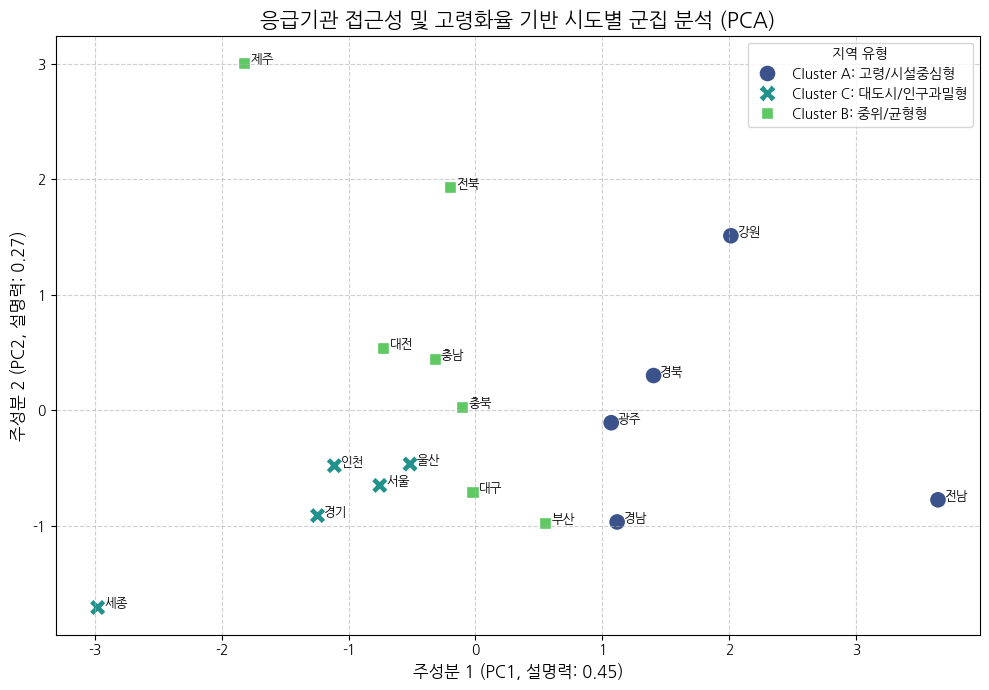

In [34]:
# --- 5. 클러스터 분석 (Step 5) ---

# 5-1. 특성(Feature) 선택
features = [
    '고령화율',
    '10만명당권역응급의료센터',
    '10만명당지역응급의료센터',
    '10만명당지역응급의료기관',
    '10만명당응급의료시설'
]
df_cluster = df_merged[['시도'] + features].copy()

# 5-2. 데이터 스케일링 및 K-Means
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster[features])
K = 3
kmeans = KMeans(n_clusters=K, random_state=195, n_init='auto')
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# 5-3. PCA를 이용한 차원 축소 및 클러스터 이름 부여
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_cluster['PC1'] = df_pca[:, 0]
df_cluster['PC2'] = df_pca[:, 1]

df_result = df_merged.merge(df_cluster[['시도', 'Cluster']], on='시도')
cluster_pc1_mean = df_cluster.groupby('Cluster')['PC1'].mean().sort_values(ascending=False)
sorted_by_pc1 = cluster_pc1_mean.index.tolist()

cluster_mapping = {
    sorted_by_pc1[0]: 'Cluster A: 고령/시설중심형',
    sorted_by_pc1[1]: 'Cluster B: 중위/균형형',
    sorted_by_pc1[2]: 'Cluster C: 대도시/인구과밀형'
}
df_result['ClusterName'] = df_result['Cluster'].map(cluster_mapping)
df_cluster['ClusterName'] = df_cluster['Cluster'].map(cluster_mapping) # 시각화에 사용

# 5-4. 클러스터 시각화 (PCA 차원 축소 결과 활용)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_cluster,
    x='PC1',
    y='PC2',
    hue='ClusterName',
    palette='viridis',
    s=150,
    style='ClusterName'
)
plt.title('응급기관 접근성 및 고령화율 기반 시도별 군집 분석 (PCA)', fontsize=15)
plt.xlabel(f'주성분 1 (PC1, 설명력: {pca.explained_variance_ratio_[0]:.2f})', fontsize=12)
plt.ylabel(f'주성분 2 (PC2, 설명력: {pca.explained_variance_ratio_[1]:.2f})', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

for i in range(len(df_cluster)):
    plt.text(df_cluster['PC1'].iloc[i] + 0.05,
             df_cluster['PC2'].iloc[i],
             df_cluster['시도'].iloc[i], fontsize=9)

plt.legend(title='지역 유형', loc='upper right')
plt.tight_layout()
plt.savefig('sido_accessibility_clustering.png')
df_result[['시도', '총인구', '고령화율'] + features + ['ClusterName']].to_csv('sido_accessibility_cluster_result.csv', index=False)

\n\n# --- 6. 시도별 총인구 규모 비교 (sido_population_comparison.png) ---


/tmp/ipython-input-3335586892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Step 6: sido_population_comparison.png 파일 생성 완료.


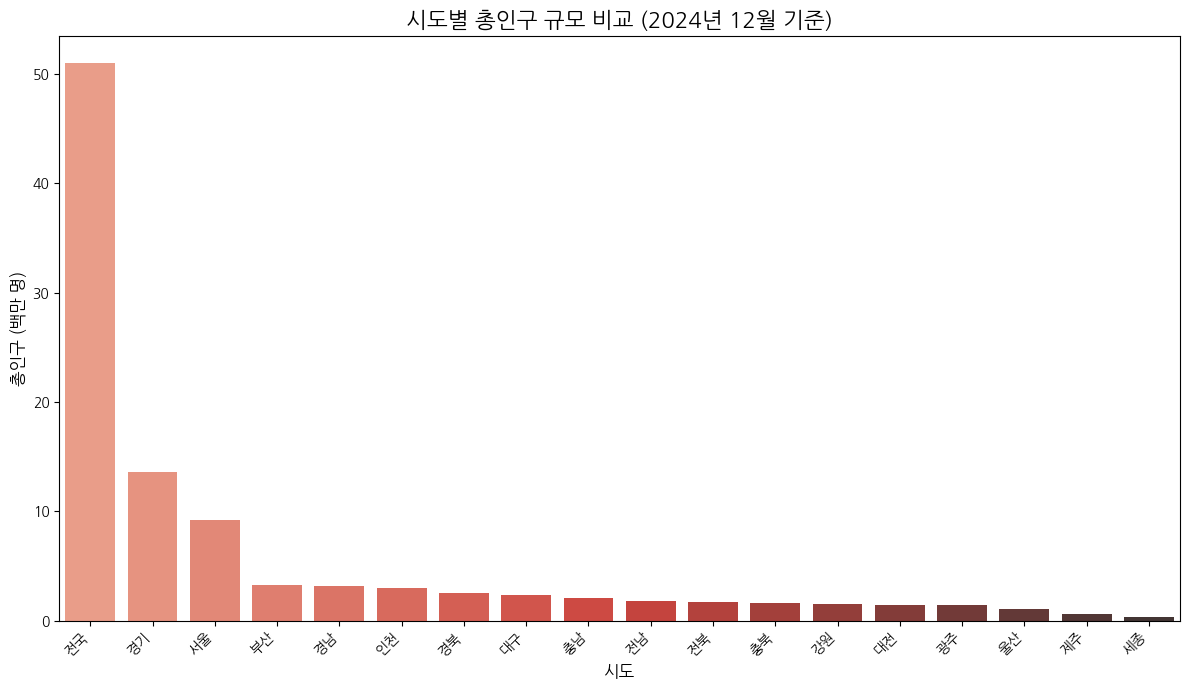

In [30]:
# --- 6. 시도별 총인구 규모 비교 (Step 6) ---
print("\\n\\n# --- 6. 시도별 총인구 규모 비교 (sido_population_comparison.png) ---")

df_pop_sido['총인구_백만'] = df_pop_sido['총인구'] / 1000000
df_pop_sido = df_pop_sido.sort_values(by='총인구_백만', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_pop_sido,
    x='시도',
    y='총인구_백만',
    palette='Reds_d'
)

plt.title('시도별 총인구 규모 비교 (2024년 12월 기준)', fontsize=16)
plt.xlabel('시도', fontsize=12)
plt.ylabel('총인구 (백만 명)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('sido_population_comparison.png')
print("Step 6: sido_population_comparison.png 파일 생성 완료.")

\n\n# --- 7. 클러스터별 평균 특징 히트맵 (cluster_feature_heatmap.png) ---


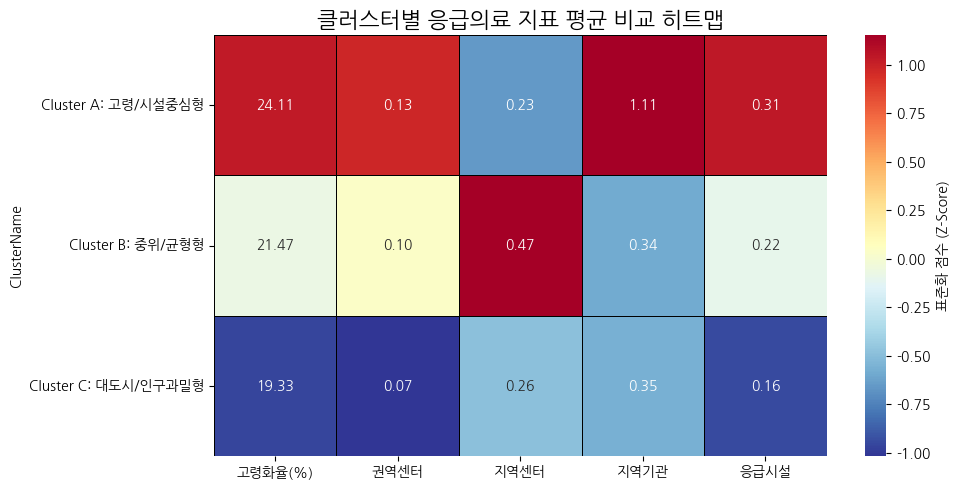

In [31]:
# --- 7. 클러스터별 평균 특징 히트맵 (Step 7) ---
print("\\n\\n# --- 7. 클러스터별 평균 특징 히트맵 (cluster_feature_heatmap.png) ---")

# ClusterName과 features를 중심으로 데이터 정리
df_heatmap = df_result.groupby('ClusterName')[features].mean()

# 컬럼 이름 간소화 (시각화용)
col_rename = {
    '10만명당권역응급의료센터': '권역센터',
    '10만명당지역응급의료센터': '지역센터',
    '10만명당지역응급의료기관': '지역기관',
    '10만명당응급의료시설': '응급시설',
    '고령화율': '고령화율(%)'
}
df_heatmap = df_heatmap.rename(columns=col_rename)

# Z-Score 정규화 (클러스터 내 상대적 비교를 위함)
df_heatmap_scaled = (df_heatmap - df_heatmap.mean()) / df_heatmap.std()

plt.figure(figsize=(10, 5))
sns.heatmap(
    df_heatmap_scaled,
    annot=df_heatmap.round(2), # 원본 값 표시
    fmt=".2f",
    cmap="RdYlBu_r", # 색상 강조
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': '표준화 점수 (Z-Score)'}
)

plt.title('클러스터별 응급의료 지표 평균 비교 히트맵', fontsize=16)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cluster_feature_heatmap.png')